In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os, sys
main_dir = os.path.dirname(os.path.abspath(''))
sys.path.insert(0, main_dir)

import models.helper as hlp
from models.custom.model import fourier_denoiser
import forward.fourier.method as fwd
from forward.fourier.kernel_creator import create_fourier_kernel

import gc
def clear_gpu():
    gc.collect()
    torch.cuda.empty_cache()


GPU_ID = 2
if torch.cuda.is_available():
    # torch.cuda.set_device(GPU_ID) # Select 5th GPU
    print(torch.cuda.device_count(), "GPU(s) available:")
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))
else:
    print("No GPUs available.")


%load_ext autoreload
%autoreload 2

5 GPU(s) available:
NVIDIA GeForce RTX 3090
NVIDIA GeForce RTX 3090
NVIDIA GeForce RTX 3090
NVIDIA GeForce RTX 3090
NVIDIA GeForce RTX 3090
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
clear_gpu()


In [8]:
minidir = '20230224_grating_data_mask_8__3_45'
dir = '/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/'+minidir +'/'
spectras = np.load(dir+'/true_spectra.npy')
wavls = np.linspace(750,850,len(spectras)) * 1e-9



In [9]:
#taken from jannik
anadir = '/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230508_mask_analysis_talbot_0_300us/'
datadir = '/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230508_mask_data_talbot_0_300us'
signalfft_center = np.load(anadir+'signalfft_padded_center.npy')
signalfft_left = np.load(anadir+'signalfft_padded_left.npy')
signalfft_right = np.load(anadir+'signalfft_padded_right.npy')

spectras = np.load(datadir+'/spectra.npy')


signal_fft = np.concatenate((signalfft_left,signalfft_center,signalfft_right),axis = 1)

wavelengths = np.arange(750,851,5)*1e-9
idx = np.zeros_like(wavelengths,dtype=int)
for i in np.arange(len(wavelengths)):
    idx[i] = (np.abs(wavls - wavelengths[i])).argmin()

wavls = wavls[idx]
signal_fft_21 = signal_fft[:,:,idx]
spectras = spectras[idx]

undisp_cube = signal_fft_21 / np.max(signal_fft_21)

undisp_cube = torch.tensor(undisp_cube).float().permute(2,0,1).unsqueeze(0).to('cuda')

mask = torch.tensor(np.load(anadir+'/dispersed_mask.npy')).float().to('cuda')
spectras = torch.tensor(spectras).float().to('cuda')
spectras = spectras / torch.max(spectras)

In [10]:
batch_size = 2

kernel = create_fourier_kernel().unsqueeze(0).permute(0,3,1,2).to('cuda')

dataset = hlp.SyntheticDataset(undispersed_cube=undisp_cube,shift_info={'kernel':kernel}, spectra = spectras)

allindexes = np.arange(len(dataset))
np.random.shuffle(allindexes)
tr_indexes = allindexes[:int(0.05*len(allindexes))]
v_indexes = allindexes[int(0.05*len(allindexes)):int(0.06*len(allindexes))]

# Create a data loader for batch processing
tr_loader = hlp.CustomDataLoader(dataset, tr_indexes, batch_size=batch_size, shuffle=True)
v_loader = hlp.CustomDataLoader(dataset, v_indexes, batch_size=batch_size, shuffle=True)

x,y = dataset[0]

model = fourier_denoiser(mask=mask, kernel=kernel)
model = model.to('cuda')

lr = 0.1
epochs = 10


optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
loss = torch.nn.MSELoss()


history1 = hlp.train(model, optimizer, loss, tr_loader, v_loader, epochs=epochs, device='cuda')


lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
history2 = hlp.train(model, optimizer, loss, tr_loader, v_loader, epochs=epochs, device='cuda')


history = {key: history1[key] + history2[key] for key in history1.keys()}

train() called: model=fourier_denoiser, opt=SGD(lr=0.100000), epochs=10, device=cuda

Epoch   1/ 10: ( 74/ 74), train loss: 0.0030581, val loss: 0.0020528
Epoch   2/ 10: ( 74/ 74), train loss: 0.0018633, val loss: 0.0016109
Epoch   3/ 10: ( 74/ 74), train loss: 0.0013319, val loss: 0.0011024
Epoch   4/ 10: ( 74/ 74), train loss: 0.00099823, val loss: 0.00093515
Epoch   5/ 10: ( 74/ 74), train loss: 0.00090796, val loss: 0.00089226
Epoch   6/ 10: ( 74/ 74), train loss: 0.00088134, val loss: 0.00087583
Epoch   7/ 10: ( 74/ 74), train loss: 0.00086906, val loss: 0.00086627
Epoch   8/ 10: ( 74/ 74), train loss: 0.00086077, val loss: 0.00085896
Epoch   9/ 10: ( 74/ 74), train loss: 0.00085404, val loss: 0.00085262
Epoch  10/ 10: ( 74/ 74), train loss: 0.00084808, val loss: 0.00084713

Time total:     243.11 sec
Time per epoch: 24.31 sec
train() called: model=fourier_denoiser, opt=SGD(lr=0.010000), epochs=10, device=cuda

Epoch   1/ 10: ( 74/ 74), train loss: 0.00084509, val loss: 0.0008466


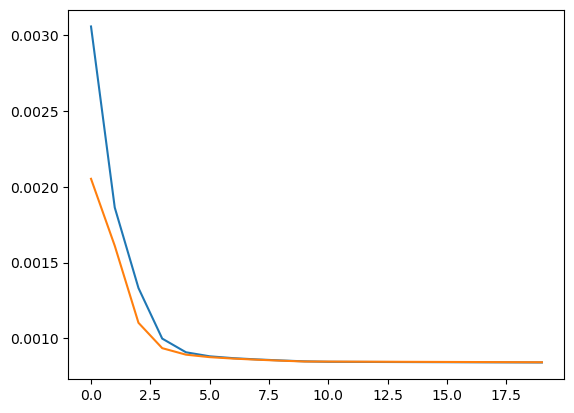

In [11]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])

In [12]:
(x,y) = dataset[v_indexes[10]]
y_pred = model(x)

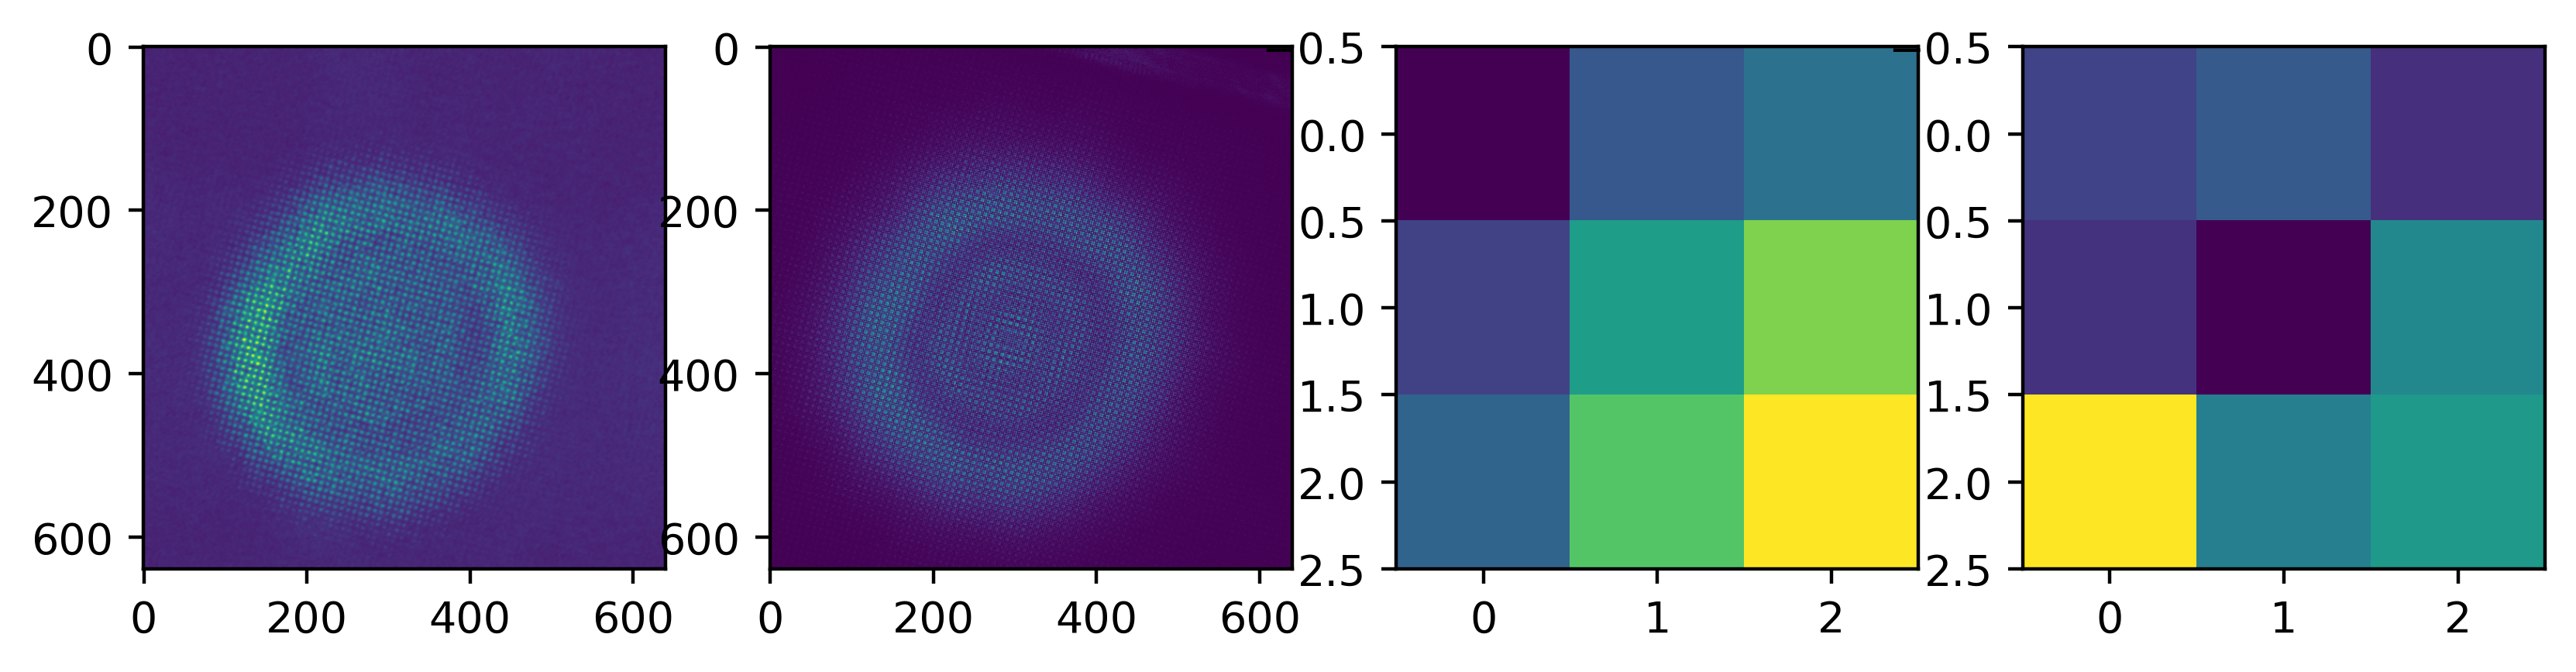

In [13]:
fig,ax = plt.subplots(1,4,figsize=(10,5),dpi=400)
ax[0].imshow(y_pred[0,10].cpu().detach().numpy())
ax[1].imshow(y[0,10].cpu().detach().numpy())

coords = [307,302]

ax[2].imshow(y_pred[0,10,coords[0]-1:coords[0]+2,coords[1]-1:coords[1]+2].cpu().detach().numpy())
ax[3].imshow(y[0,10,coords[0]-1:coords[0]+2,coords[1]-1:coords[1]+2].cpu().detach().numpy())

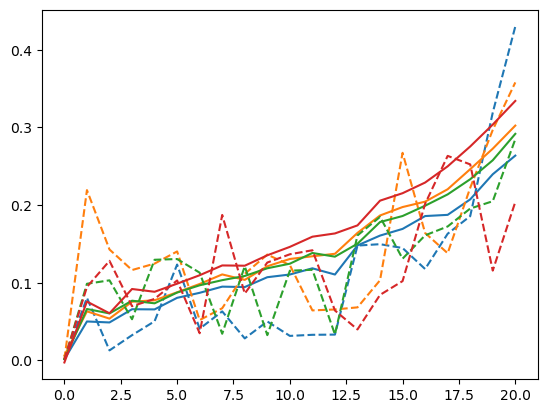

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(2):
    for j in range(2):
        line, = ax.plot(y_pred[0,:,coords[0]+i,coords[1]+j].cpu().detach().numpy())
        ax.plot(y[0,:,coords[0]+i,coords[1]+j].cpu().detach().numpy(),color = line.get_color(),linestyle='--')

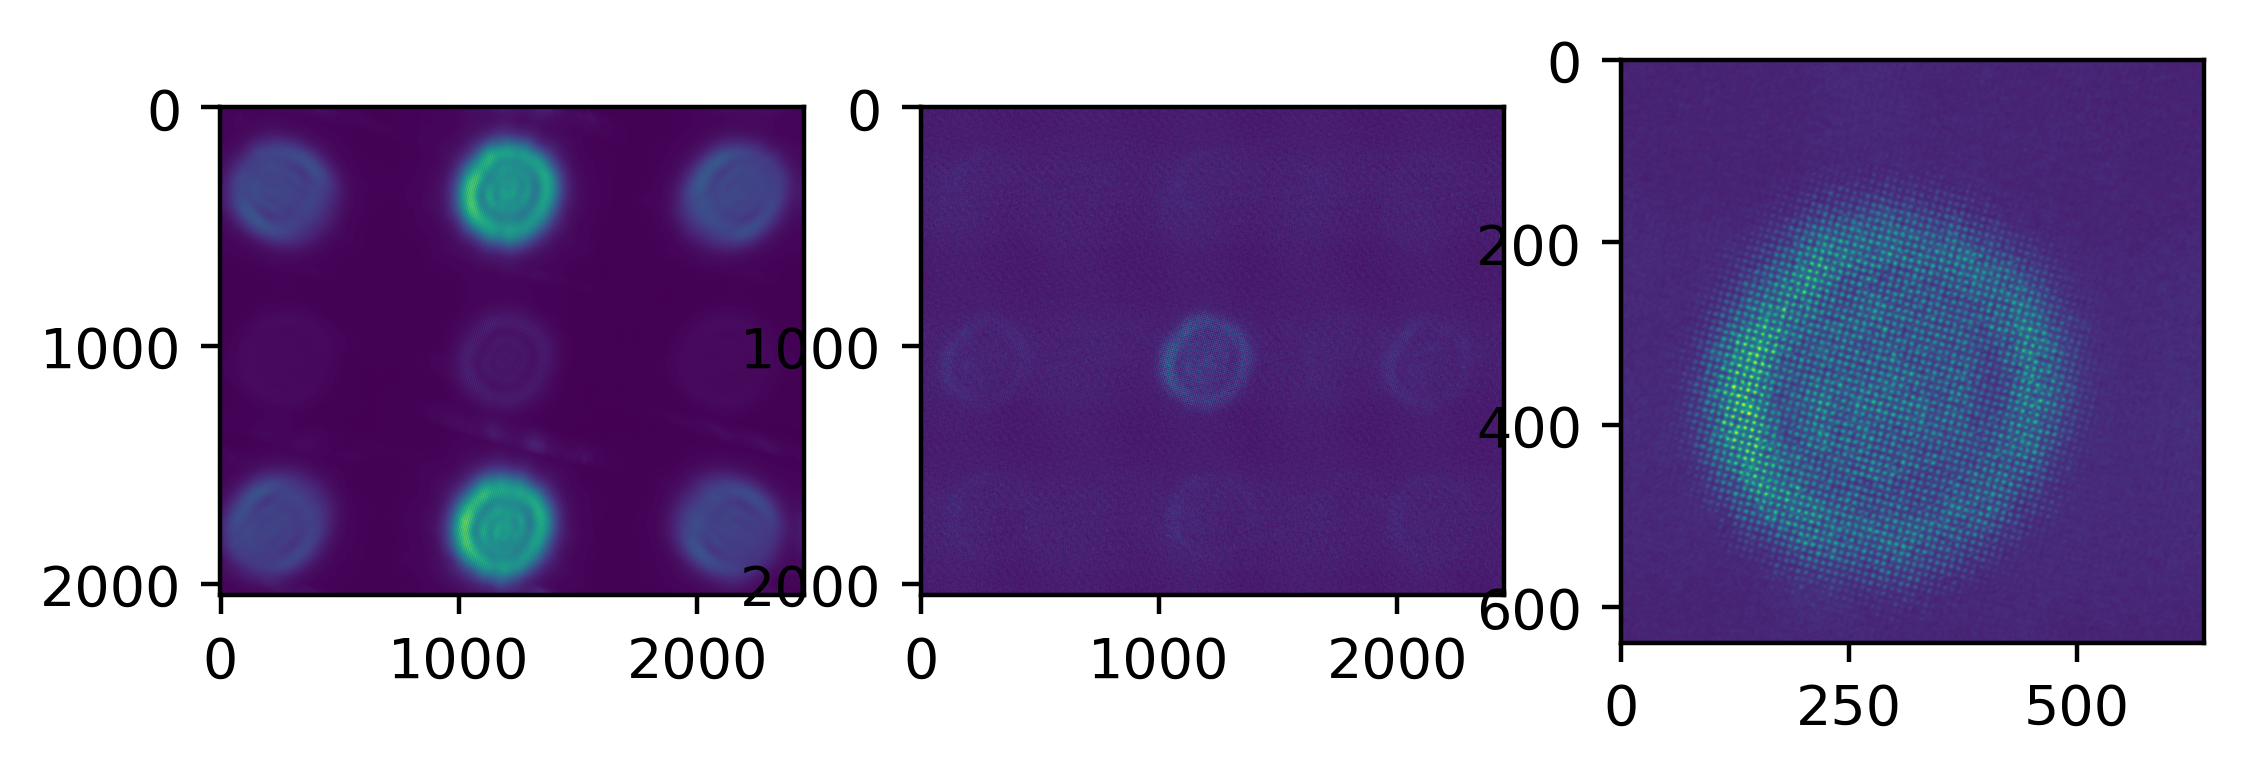

In [15]:
fig,ax = plt.subplots(1,3,dpi=400)
ax[0].imshow(x[0].cpu().detach().numpy())
ax[1].imshow(model.data_term(x)[0,10].cpu().detach().numpy())
ax[2].imshow(model(x)[0,10].cpu().detach().numpy())

In [16]:
model.data_term(x).shape

torch.Size([1, 21, 2048, 2448])